### 1. Problem statement
- you have been tasked to automate the process of detecting and classifying chest disease and reduce the cost and time of detection. 
- The team has collected extensive X-Ray chest data and they approached you to develop a model that could detect and classify the diseases in less than 1 minute. 
- You have been provided with 133 images that belong to 4 classes: 
 - Healthy 
 - Covid-19
 - Bacterial Pneumonia
 - Viral Pneumonia 


### 2. Import library

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, SeparableConv2D
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.compat.v1.set_random_seed(111)

# Define a tensorflow session with above session configs
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Set the session in keras
# K.set_session(sess)

### 3. Read & Prepare data

In [3]:
train_data_dir = os.path.join(os.getcwd(), 'Train')

In [4]:
train_data_dir

'C:\\Users\\KX764QE\\Documents\\courses\\4. Operations Department\\Train'

- This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
-  Each class contains 133 images.
-  Dataset Source:
- https://github.com/ieee8023/covid-chestxray-dataset 
-  https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

use image generator to generate tensor image data and normalize them

In [5]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

- generate batches of 40 images  
- total number of images are 133*4 = 532
- training is 80% and valiation is 20%
- perform shuffling and reszing

In [6]:
train_generator = image_generator.flow_from_directory(batch_size = 40, 
                                                      directory= train_data_dir, 
                                                      shuffle = True, 
                                                      target_size = (256, 256), #pixel size
                                                      class_mode = 'categorical', #categorical classfication
                                                      subset= 'training')

Found 428 images belonging to 4 classes.


In [7]:
# validation_generator = image_generator.flow_from_directory(batch_size = 40, 
#                                                       directory= train_data_dir, 
#                                                       shuffle = True, 
#                                                       target_size = (256, 256), #pixel size
#                                                       class_mode = 'categorical', #categorical classfication
#                                                       subset= 'validation')

In [8]:
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
label_names = {0: 'Covid19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

### 4. Data visualization

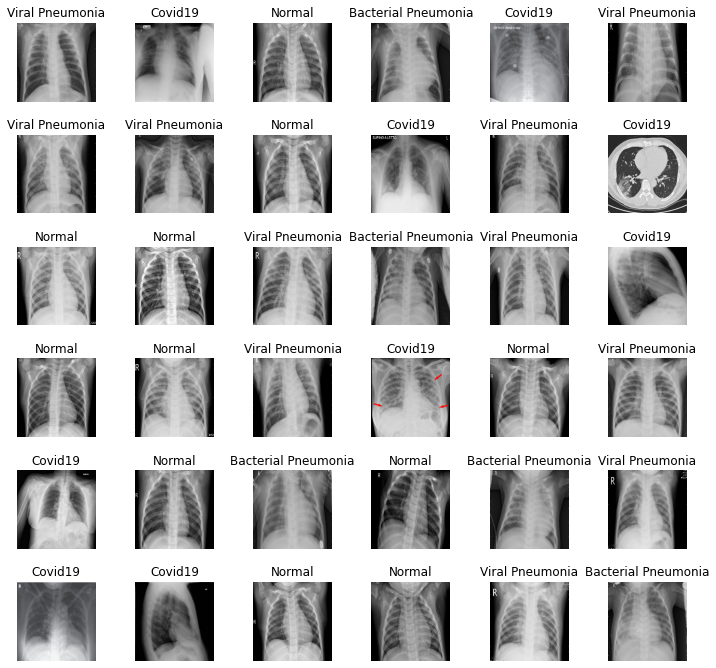

In [12]:
l = 6
w = 6
fig, axes = plt.subplots(l, w, figsize = (12, 12))
axes = axes.ravel() #flatten axis

for i in np.arange(0, l*w):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')


    plt.subplots_adjust(wspace = 0.5)

#### Vanishing gradient
- Vanishing gradient: as CNN grows deeper, vanishing gradient occurs. 
- It occurs when the gradient is back-propagated to earlier layers which results in small gradients.  
- Residual Neural Network includes 'skip-connection' feature which enable training of 152 layers with gradient vanishing.
- ImageNet contain 11 million images and 11000 categories
- ImageNet is used to train ResNet 

#### Transfer learning
 - copy and freeze the middle feature layers  
 - train with new data  
 - create new custom layers at the end to perform classification on specific task

### 5. Import pre-trained model

 - model trained with imagenet dataset 
 - no classification head
 - input in shape of cutom image size
<!--  - 50 layers deep  -->

In [13]:
# basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

basemodel = InceptionV3(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [14]:
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [15]:
#freeze the layers in bottom
for layer in basemodel.layers[: -10]:
    layer.trainable = False

### 6. Create & Train model

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)

headmodel = Flatten(name= 'flatten')(headmodel)

headmodel = Dense(256, activation = "relu")(headmodel)
# headmodel = BatchNormalization()(headmodel)
headmodel = Dropout(0.5)(headmodel)

headmodel = Dense(64, activation = "relu")(headmodel)
# headmodel = BatchNormalization()(headmodel)
headmodel = Dropout(0.5)(headmodel)

headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [17]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizers.RMSprop(lr = 1e-4, decay = 1e-6), 
              metrics = ['accuracy'])


In [18]:
#use early stopping to monitor validation loss, stop if val_loss not decreasing after certain number of epochs
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

#save the model with lowest val_loss
checkpointer = ModelCheckpoint(filepath = 'weights.hdfs', verbose = 1, save_best_only=True)

In [19]:
train_generator = image_generator.flow_from_directory(batch_size=4, 
                                                     directory=train_data_dir,
                                                     shuffle=True, 
                                                      target_size=(256, 256),
                                                     class_mode='categorical',
                                                      subset = 'training'
                                                     )

Found 428 images belonging to 4 classes.


In [20]:
val_generator = image_generator.flow_from_directory(batch_size=4, 
                                                     directory=train_data_dir,
                                                     shuffle=True, 
                                                      target_size=(256, 256),
                                                     class_mode='categorical',
                                                      subset = 'validation'
                                                     )

Found 104 images belonging to 4 classes.


In [21]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch= train_generator.n // 4, 
                              epochs = 20, 
                              validation_data= val_generator, 
                              validation_steps= val_generator.n // 4, 
                              callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 1.5395 - accuracy: 0.3178
Epoch 00001: val_loss improved from inf to 1.14484, saving model to weights.hdfs
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: weights.hdfs\assets
107/107 [==============================] - 171s 2s/step - loss: 1.5395 - accuracy: 0.3178 - val_loss: 1.1448 - val_accuracy: 0.6058
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 1.2328 - accuracy: 0.4486
Epoch 00002: val_loss improved from 1.14484 to 0.99466, saving model to weights.hdfs
INFO:tensorflow:Assets written to: weights.hdfs\assets
107/107 [==============================] - 165s 2s/step - loss: 1.2328 - accuracy: 0.4486 

### 7. Evaluate model

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

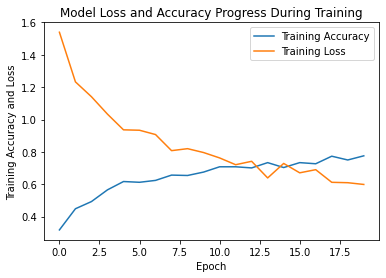

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])


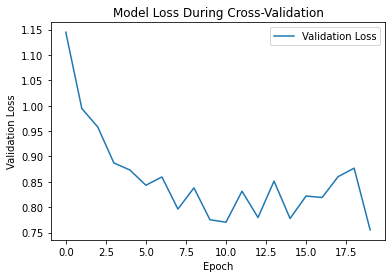

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

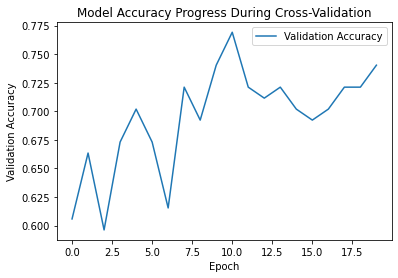

In [25]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [26]:
test_dir = os.path.join(os.getcwd(), 'Test')

In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, 
                                             directory = test_dir, 
                                             shuffle = True,
                                             target_size = (256, 256),
                                              class_mode = 'categorical'
                                             )

Found 40 images belonging to 4 classes.


In [28]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4, verbose = 1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
 1/10 [==>...........................] - 0s 193ms/step - loss: 0.9990 - accuracy: 0.6250


In [29]:
print('Accuracy during test: {}'.format(evaluate[1]))

Accuracy during test: 0.625


In [30]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_dir))):
  for item in os.listdir(os.path.join(test_dir,str(i))):
    img= cv2.imread(os.path.join(test_dir,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [31]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))


Test Accuracy : 0.675


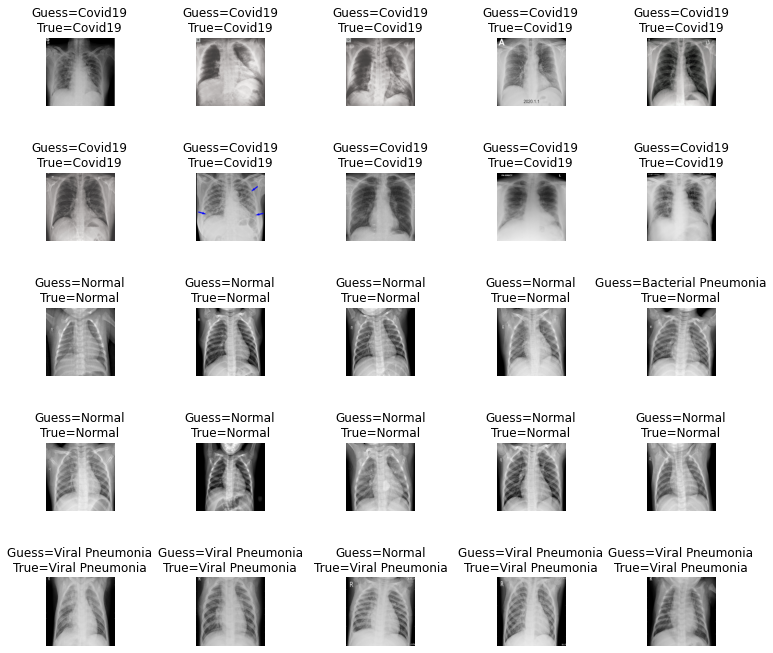

In [32]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [33]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.64      0.90      0.75        10
           2       0.67      0.40      0.50        10
           3       0.57      0.40      0.47        10

    accuracy                           0.68        40
   macro avg       0.66      0.67      0.65        40
weighted avg       0.66      0.68      0.65        40



Text(0.5, 1.0, 'Confusion_matrix')

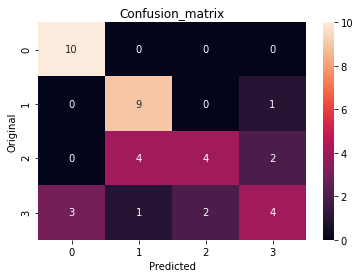

In [34]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')